<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])

In [ ]:
aa_idx = aa_encode.codes

In [ ]:
aa_coords = {"aa": aa_encode.categories}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 1)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 1)
    μ_nu = pm.HalfStudentT('μ_nu', sigma = 10, nu = 1)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10,
                        nu = 1,
                      dims = "aa")

    nu = pm.Exponential('nu', lam = 1, dims = "aa")

    #likelihood; now using StudentT
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = nu[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

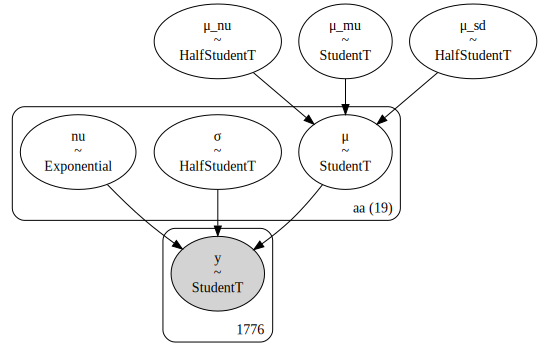

In [ ]:
pm.model_to_graphviz(cs_h_model)

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model_n:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h_n = pm.sample()

Output()

Output()

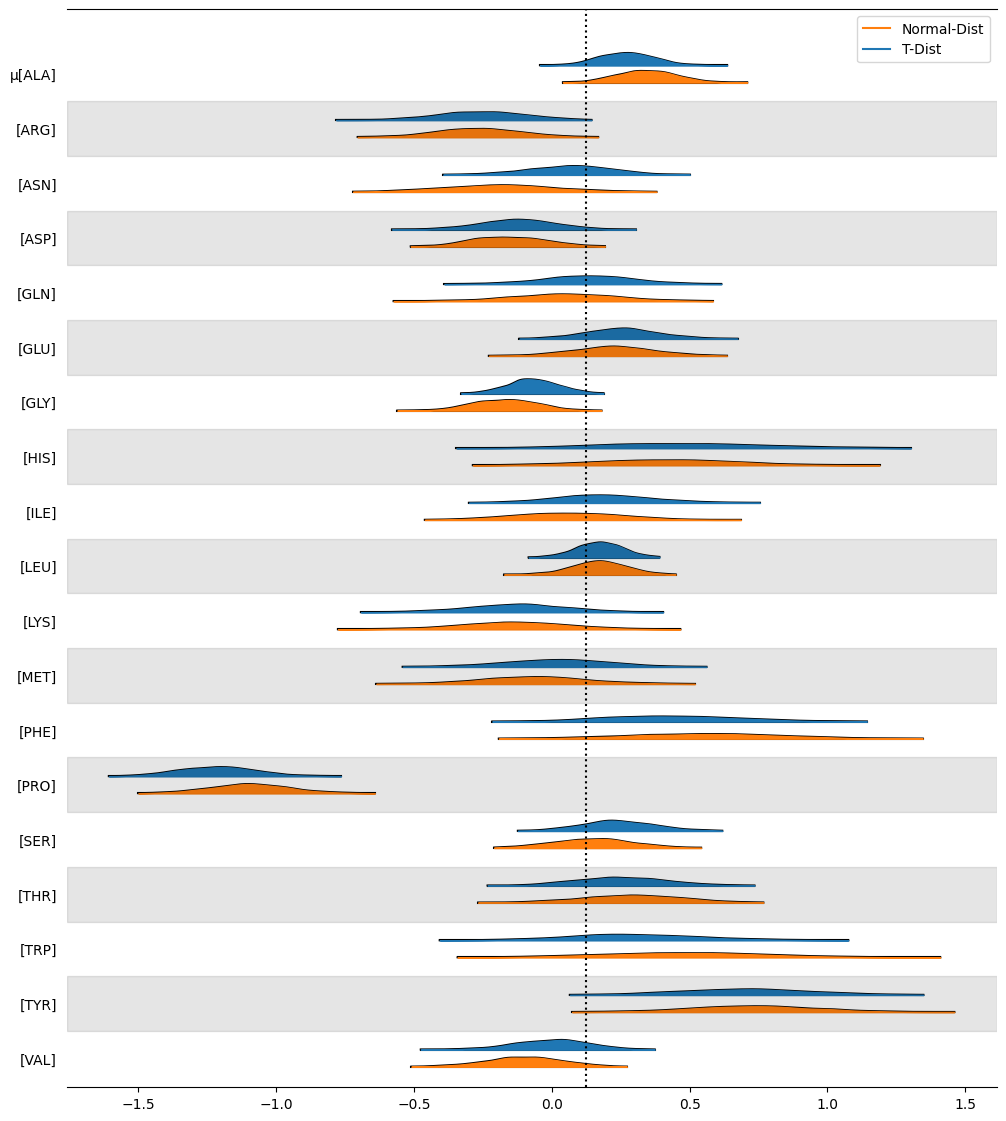

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_h_n], kind="ridgeplot",
                      model_names=['T-Dist', 'Normal-Dist'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(-10.0, 10.0)

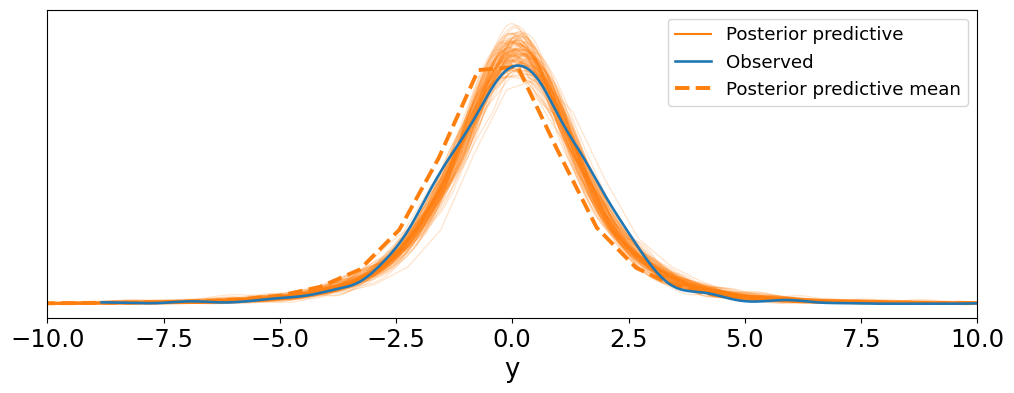

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.xlim([-10,10]) #:O thx chatgpt ("Is it possible to limit the range displayed on a python avriz ppc graph")

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_n, model=cs_h_model_n, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:700: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:700: RuntimeWarning: invalid value encountered in divide
  f = grid_counts / bin_width / len(x)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:703: RuntimeWarning: invalid value encountered in scalar divide
  bw /= bin_width


ValueError: cannot convert float NaN to integer

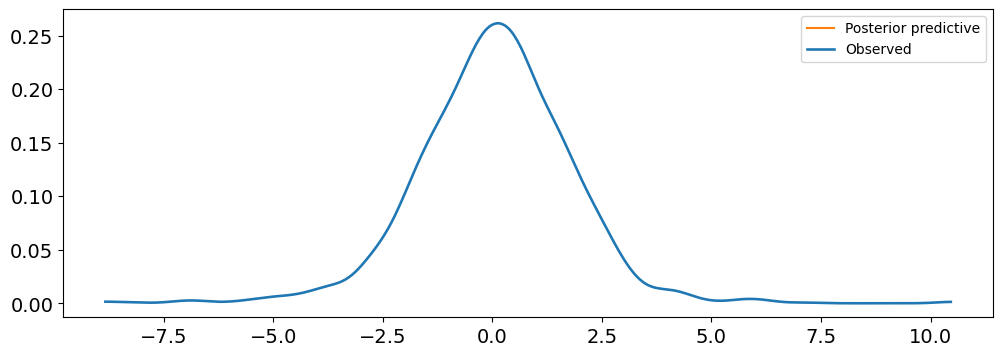

In [ ]:
idata_cs_h_n.posterior_predictive = idata_cs_h_n.posterior_predictive.fillna(0)
az.plot_ppc(idata_cs_h_n, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#plt.xlim([-10,10])

I cannot get this code to run, I've tried several things to try and rid the NaN problem, and Idk why it only breaks here. When running the ridge plot it functions fine, so it has to be something wrong with the predictive sampling.
I'm gonna assume my T-Dist works better here since more of the values were included on the zero line.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
pos_idx = sccr_data.position.cat.codes.values #array of the soccer positions, except they are given an int (number) label instead of a string (of letters)

pos_codes = sccr_data.position.cat.categories #an array of the four strings that represent position

sccr_coords = {"pos": pos_codes} #puts coords in a dict, so pymc can read them

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model_nh:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20, dims = "pos") #Add dims to make independent
    ν = pm.Gamma('ν', mu = 55, sigma = 45, dims = "pos") #Add dims to make independent


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_nh = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

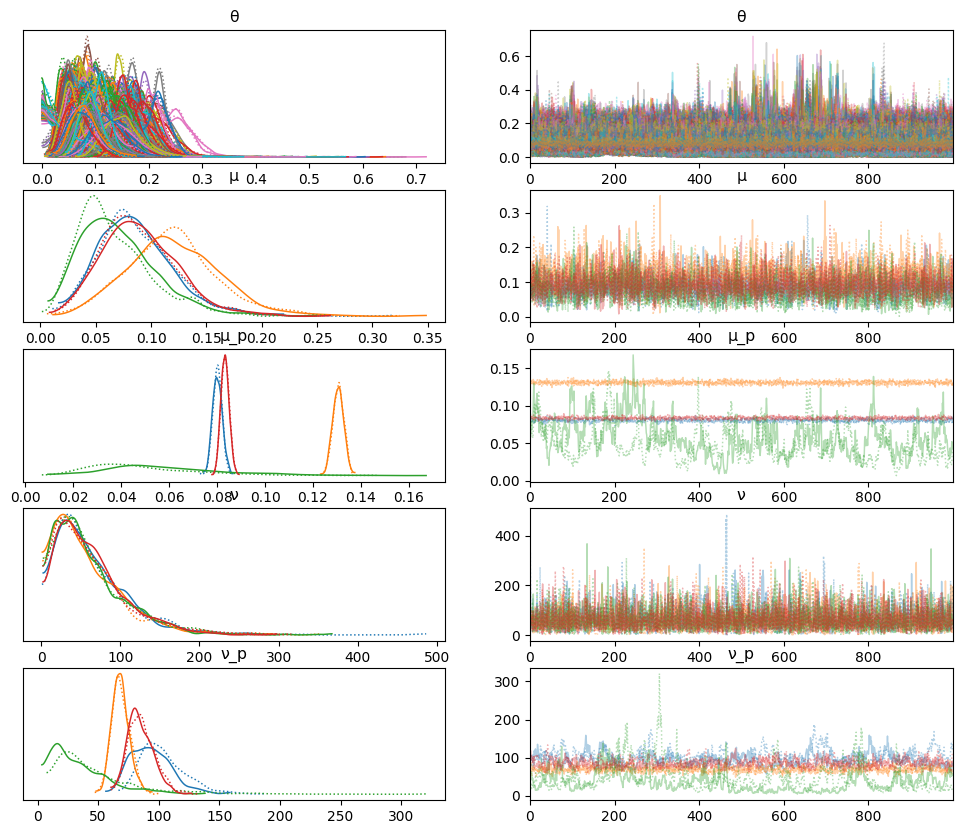

In [ ]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
#...which also takes 6 to 8 minutes to run
az.plot_trace(idata_sccr_nh)

In [ ]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.0 1.001 1.0 ... 1.0 1.005 1.0 0.9995
    μ        (pos) float64 32B 0.9998 1.002 1.012 1.0
    μ_p      (pos) float64 32B 1.009 0.9996 1.067 0.9999
    ν        (pos) float64 32B 1.0 1.001 1.0 1.0
    ν_p      (pos) float64 32B 1.055 1.001 1.102 1.005

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

In general the Non-hierarchical soccer model did better with its GK v_p value beign 1.102 compared to 1.27 it had in the other model, however some of its othet values performed worse when given per class comapred to as a whole. Mu in general on the Heirarchy performed well, but here on GK it did worse, this is to be expected from data without alot of data.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

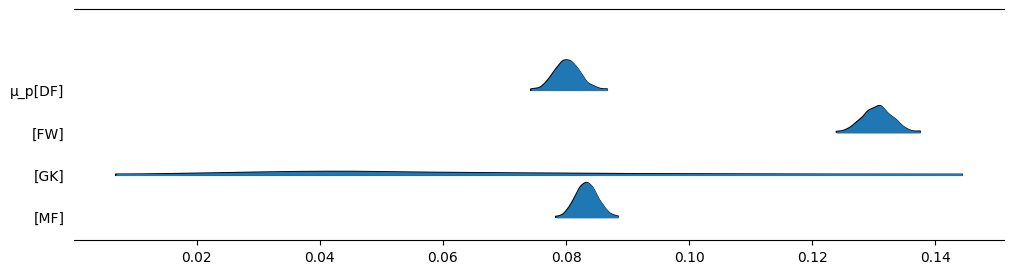

In [ ]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

This looks basically the same except that the GK position varied so much that the axis are different between the two views. Other than that the means seem to be very similarly centered and distributed.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
pos_idx = sccr_data.position.cat.codes.values #array of the soccer positions, except they are given an int (number) label instead of a string (of letters)
filt = np.nonzero(sccr_data.position != 'GK')
filt_shots = sccr_data.shots.values[filt]
filt_goals = sccr_data.goals.values[filt]

pos_codes = sccr_data.position.cat.categories #an array of the four strings that represent position

pos_idx = pos_idx[filt]
pos_idx[np.nonzero(pos_idx == 2)] = 1
pos_idx[np.nonzero(pos_idx == 3)] = 2
pos_codes = [x for x in pos_codes if x != 'GK']

sccr_coords = {"pos": pos_codes} #puts coords in a dict, so pymc can read them

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model_h:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20) #Remove dims to make heirarchical again
    ν = pm.Gamma('ν', mu = 55, sigma = 45) #Remove dims to make heirarchical again


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = filt_shots, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = filt_goals) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_h = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: >], dtype=object)

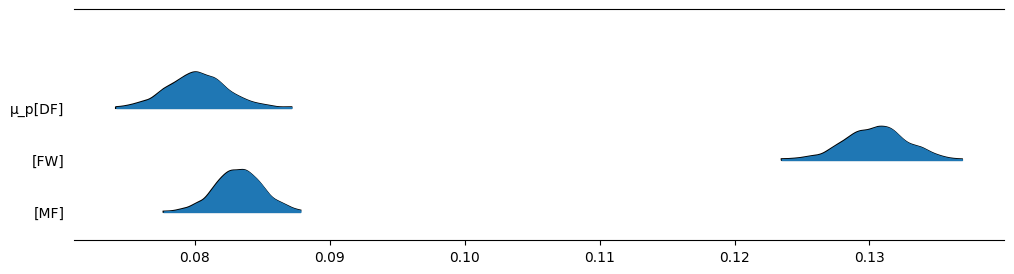

In [ ]:
az.plot_forest(idata_sccr_h, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [ ]:
az.rhat(idata_sccr_h)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.005 1.0 1.001 1.001 ... 1.001 1.006 1.002
    μ        float64 8B 1.001
    μ_p      (pos) float64 24B 1.001 0.9997 1.003
    ν        float64 8B 1.001
    ν_p      (pos) float64 24B 1.004 1.001 1.002

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

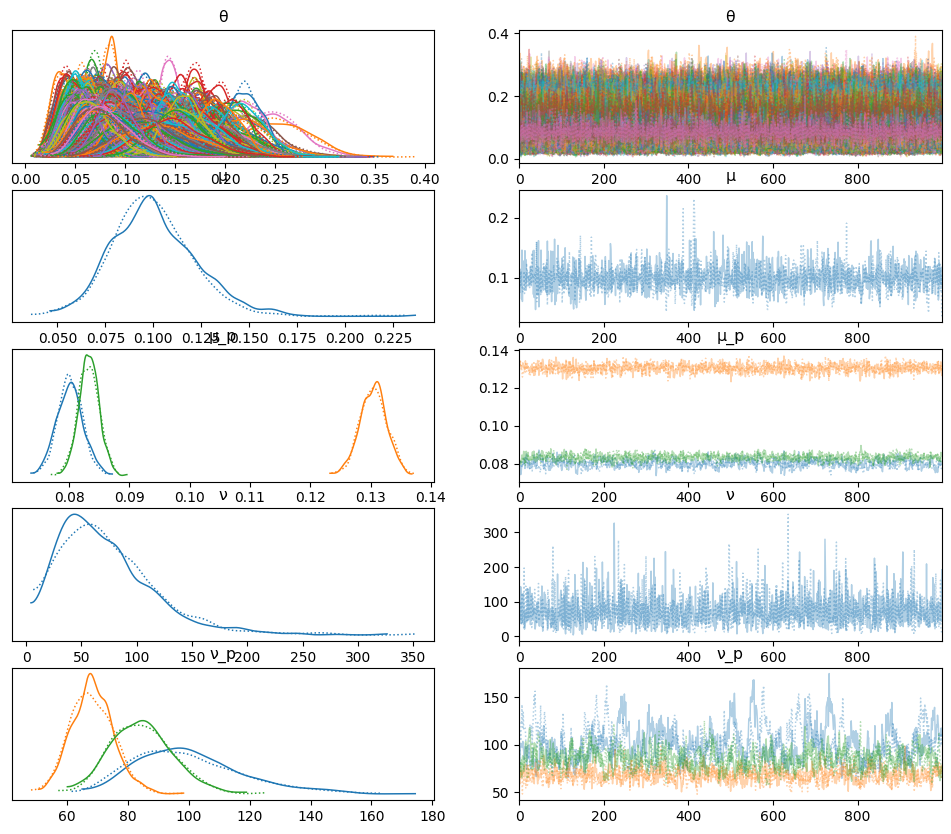

In [ ]:
az.plot_trace(idata_sccr_h)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

Pymc ran much much quicker on the model without GKs, it still felt the need to tell me it wasnt accurate as it had groups w/o enough samples, but I dont know what it's talking about. By not including GKs we get a (heirarchical) relationship between the offensive (ish) positions that might reasonably attempt scoring. However, we disclude the possibility that there is some characteristic shared by all soccer players that might infleunce goal scoring (like maybe general dexterity and ball control).